# Regresion Basica: Predecir eficiencia de gasolina

Este libro usa el set de datos clasico [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) y construye un modelo para predecir el consumo de vehiculos de 1970 y 1980. Para hacer esto proveeremos el modelo con una descripcion de muchos automoviles de ese periodo. Esta descripcion incluye atributos como: Cilindros, desplazamiento, potencia y peso.

El objetivo de este ejercicio es predecir el target miles per galon (MPG), que vendría a representar las millas por galón de combustible.

Este ejemplo usa el API `tf.keras` , revise [Esta Guia](https://www.tensorflow.org/guide/keras) para obtener mas detalles.

In [142]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
import keras 
import tensorflow as tf


## El set de Datos de MPG

El set de datos esta disponible de el siguiente repositorio [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).

### Obtenga los datos
Primero descargue el set de datos.
keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

In [143]:
datos = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

Importelo usando pandas.

In [144]:
column_names = [
    "mpg", "cylinders", "displacement", "horsepower", "weight",
    "acceleration", "model_year", "origin", "car_name"
]

In [145]:
df = pd.read_csv(datos, names=column_names, sep='\s+', na_values="?", quotechar='"')
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52.0,2130.0,24.6,82,2,vw pickup
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,dodge rampage
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,ford ranger


In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car_name      398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


### Limpia los datos

Trata los missings y variables categóricas

In [147]:
df["horsepower"].fillna(df["horsepower"].mean(),inplace=True)

C:\Users\rafac\AppData\Local\Temp\ipykernel_20888\810759998.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["horsepower"].fillna(df["horsepower"].mean(),inplace=True)


In [148]:
df["model_year"].unique()

array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82])

In [149]:
df["origin"].unique()

array([1, 3, 2])

In [150]:
df["mpg"] = np.log(df["mpg"] +1)

### Divide los datos en train y test

Ahora divida el set de datos en un set de entrenamiento y otro de pruebas. 80% para entrenamiento

Usaremos el set de pruebas en la evaluacion final de nuestro modelo.

NOTA: El resultado tienen que ser dos datasets

In [151]:
train = df.sample(frac=0.8,random_state=42)
test = df.drop(train.index)

In [152]:
print(train.shape)
print(test.shape)

(318, 9)
(80, 9)


### Inspecciona los datos

Revise rapidamente la distribucion conjunta del dataset de entrenamiento mediante un grid de gráficos

<Axes: >

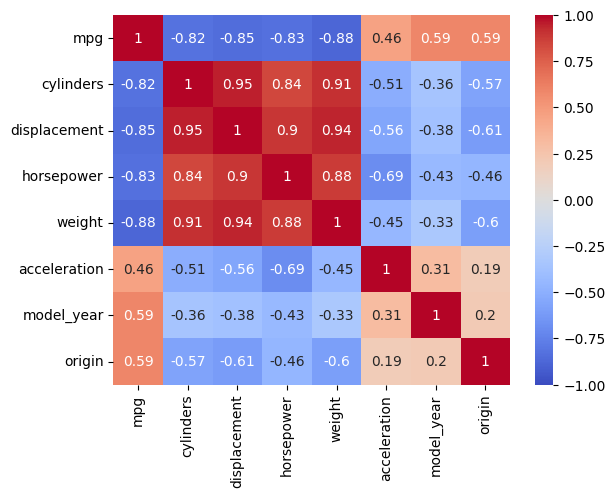

In [153]:
sns.heatmap(train.corr(numeric_only=True),vmin=-1,cmap="coolwarm",annot=True)

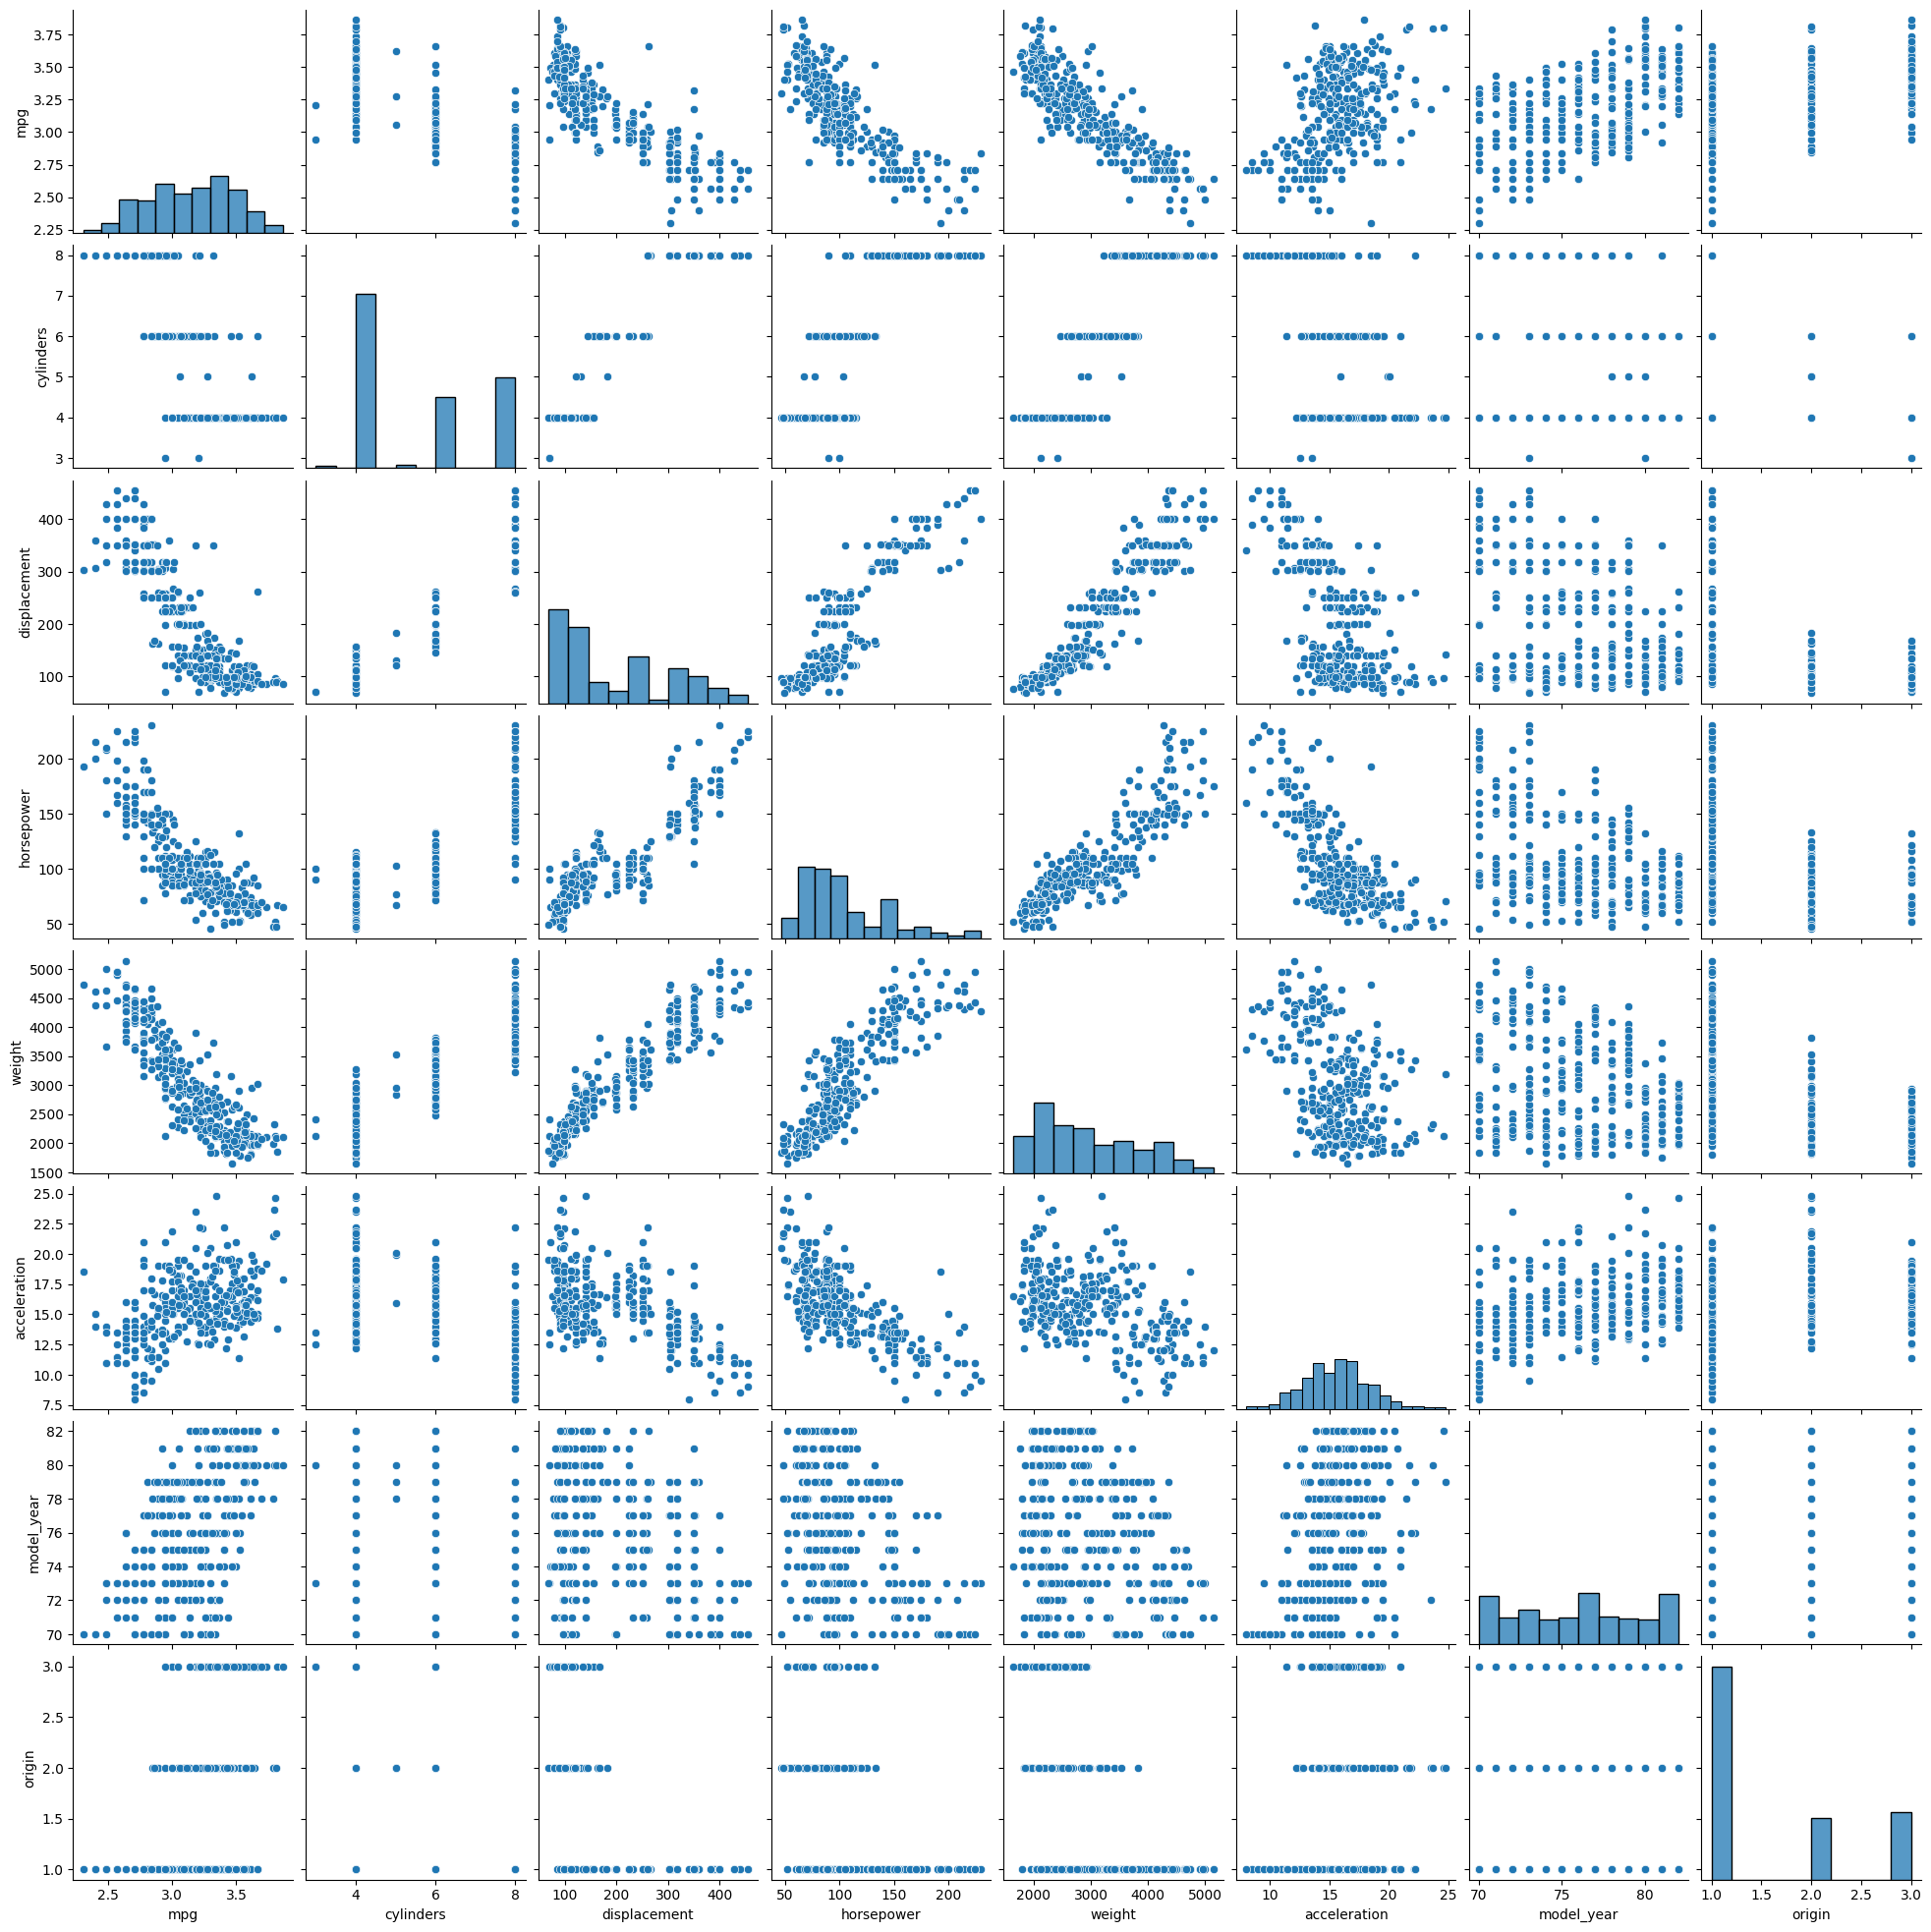

In [154]:
sns.pairplot(train)

Tambien revise las estadisticas generales:

### Separa las features del target

Separe el target de las features.

In [155]:
x_train = train.drop(columns=["mpg","car_name"])
y_train = train["mpg"]
x_val = test.drop(columns=["mpg","car_name"])
y_val = test["mpg"]

### Estandariza los datos

Es una buena práctica estandarizar funciones que utilizan diferentes escalas y rangos. Aunque el modelo podría converger sin estandarizar, dificulta el entrenamiento y hace que el modelo resultante dependa de la elección de las unidades utilizadas en la entrada.

In [156]:
scaler = StandardScaler()
x_train_scal = scaler.fit_transform(x_train)
x_val_scal = scaler.transform(x_val)

Estos datos estandarizados es lo que usaremos para entrenar el modelo.

## El modelo

### Construye el modelo

Construyamos nuestro modelo. Aquí, utilizaremos un modelo `secuencial` con dos capas ocultas densamente conectadas y una capa de salida que devuelve un único valor continuo.

Por tanto, tendrá tres capas. Una de entrada con activación relu. Otra hidden layer con activación relu y la de salida de regresión, que se compondrá de una única neurona. Pon las neuronas que consideres para las dos primeras capas.

Para el compile utiliza un loss='mse'.

optimizer = `tf.keras.optimizers.RMSprop(0.001)`

Y en metrics añade en una lista el `mae` y `mse`.

In [157]:
x_train_scal.shape[1:]

(7,)

In [158]:
model = keras.models.Sequential([
    keras.Input(shape=(7,)),  
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])

model.compile(optimizer= tf.keras.optimizers.RMSprop(0.001), loss='mse', metrics=['mae','mse'])


### Inspeccione el modelo

Use el método `.summary` para imprimir una descripción simple del modelo

In [159]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 577 (2.25 KB)

 Trainable params: 577 (2.25 KB)

 Non-trainable params: 0 (0.00 B)

### Entrenar el modelo

Entrene el modelo para 1000 epochs y guarda los resultados del entrenamiento en una variable llamada `history`.
Emplea en el entrenamiento un 20% de los datos para validación, mediante el argumento `validation_split`.

NOTA: recuerda usar los datos normalizados.

In [160]:
history = model.fit(x_train_scal,y_train,epochs = 1000,validation_data =(x_val_scal,y_val),verbose=2)

Epoch 1/1000
10/10 - 1s - 62ms/step - loss: 8.5888 - mae: 2.8949 - mse: 8.5888 - val_loss: 7.4736 - val_mae: 2.7018 - val_mse: 7.4736
Epoch 2/1000
10/10 - 0s - 11ms/step - loss: 6.5935 - mae: 2.5220 - mse: 6.5935 - val_loss: 6.0040 - val_mae: 2.4056 - val_mse: 6.0040
Epoch 3/1000
10/10 - 0s - 12ms/step - loss: 5.2402 - mae: 2.2239 - mse: 5.2402 - val_loss: 4.8258 - val_mae: 2.1386 - val_mse: 4.8258
Epoch 4/1000
10/10 - 0s - 11ms/step - loss: 4.1373 - mae: 1.9489 - mse: 4.1373 - val_loss: 3.8207 - val_mae: 1.8823 - val_mse: 3.8207
Epoch 5/1000
10/10 - 0s - 11ms/step - loss: 3.2030 - mae: 1.6822 - mse: 3.2030 - val_loss: 2.9512 - val_mae: 1.6342 - val_mse: 2.9512
Epoch 6/1000
10/10 - 0s - 11ms/step - loss: 2.4214 - mae: 1.4372 - mse: 2.4214 - val_loss: 2.2270 - val_mae: 1.3958 - val_mse: 2.2270
Epoch 7/1000
10/10 - 0s - 12ms/step - loss: 1.7895 - mae: 1.2153 - mse: 1.7895 - val_loss: 1.6399 - val_mae: 1.1717 - val_mse: 1.6399
Epoch 8/1000
10/10 - 0s - 11ms/step - loss: 1.2966 - mae: 1.00

Visualice el progreso de entrenamiento del modelo usando las estadísticas almacenadas en el objeto `history`.

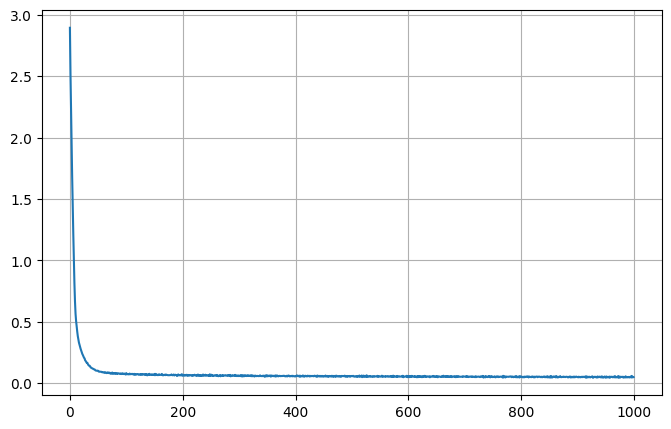

In [161]:
pd.DataFrame(history.history["mae"]).plot(figsize=(8, 5),legend=False)
plt.grid(True)



¿Alguna conclusión respecto a este gráfico?

El numero de epocas podría haber sido mucho mas bajo, a partir de 20-30 no hay demasiada diferencia

Earlystopping me ha ayudado a detener el entrenamiento para no caer en overfitting, también para ahorrar recursos innecesarios.

Observamos que si le damos muchas epochs al entrenamiento tiende a un overfitting, siendo el error en validación cada vez más alto. Sería interesante utilizar un número aprox de 30 epochs

Añade un early stopping al modelo. Pon el argumento `callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]` dentro del fit().

Visualiza el progreso de entrenamiento.

In [139]:
history2 = model.fit(x_train_scal,y_train,epochs = 1000,validation_data =(x_val_scal,y_val),verbose=2,callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/1000
10/10 - 0s - 13ms/step - loss: 0.0074 - mae: 0.0648 - mse: 0.0074 - val_loss: 0.0140 - val_mae: 0.0948 - val_mse: 0.0140
Epoch 2/1000
10/10 - 0s - 10ms/step - loss: 0.0085 - mae: 0.0707 - mse: 0.0085 - val_loss: 0.0146 - val_mae: 0.0946 - val_mse: 0.0146
Epoch 3/1000
10/10 - 0s - 10ms/step - loss: 0.0078 - mae: 0.0663 - mse: 0.0078 - val_loss: 0.0174 - val_mae: 0.1062 - val_mse: 0.0174
Epoch 4/1000
10/10 - 0s - 11ms/step - loss: 0.0074 - mae: 0.0649 - mse: 0.0074 - val_loss: 0.0134 - val_mae: 0.0896 - val_mse: 0.0134
Epoch 5/1000
10/10 - 0s - 11ms/step - loss: 0.0078 - mae: 0.0663 - mse: 0.0078 - val_loss: 0.0137 - val_mae: 0.0912 - val_mse: 0.0137
Epoch 6/1000
10/10 - 0s - 10ms/step - loss: 0.0076 - mae: 0.0651 - mse: 0.0076 - val_loss: 0.0135 - val_mae: 0.0898 - val_mse: 0.0135
Epoch 7/1000
10/10 - 0s - 12ms/step - loss: 0.0072 - mae: 0.0644 - mse: 0.0072 - val_loss: 0.0143 - val_mae: 0.0984 - val_mse: 0.0143
Epoch 8/1000
10/10 - 0s - 12ms/step - loss: 0.0073 - mae: 0.06

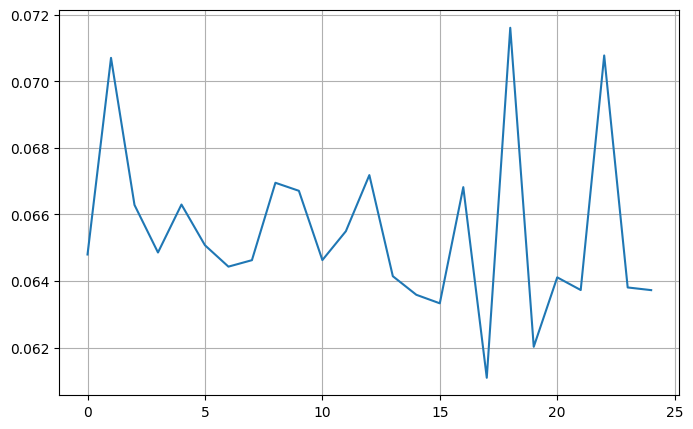

In [140]:
pd.DataFrame(history2.history["mae"]).plot(figsize=(8, 5),legend=False)
plt.grid(True)


Interpreta el gráfico

Veamos qué tan bien generaliza el modelo al usar el conjunto de **test**. Esto nos dice qué tan bien podemos esperar que el modelo prediga cuándo lo usamos en el mundo real. Utiliza el método `evaluate` con los datos de test normalizados y sus labels.

Con el método evaluate devolverá tres valores: loss, mae y mse.

Ahora prueba el modelo. Coge 10 ejemplos de test y llama a` model.predict`.

### Haz Predicciones

Dibuja en un scatter plot las predicciones de test vs sus true labels.

Parece que nuestro modelo predice razonablemente bien. Echemos un vistazo a la distribución de errores.

Representa los residuos en un histograma

No es del todo gaussiano, pero podríamos esperar eso porque el número de muestras es muy pequeño.

Guarda tu modelo en un archivo.